In [1]:
!pip3 install datasets
!pip3 install apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 32.4 MB/s eta 0:00:0000:0100:01
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78545 sha256=71d5008464069be933d561fc62ea8a0692832f5d0b86503fcb6cd93131e33e94
  Stored in directory: /root/.cache/pip/wheels/ea/e2/86/64980d90e297e7bf2ce588c2b96e818f5399c515c4bb8a7e4f
Successfully built dill
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.1 requires 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
!pip3 install gdown
import gdown
import random
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dropout, LayerNormalization, Dense, Bidirectional, LSTM
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.activations import softmax
from sklearn.model_selection import train_test_split

In [4]:
#Project specifications
vocab_size = 10000
length_min = 3
length_max = 30
#max_params=20000000
#no pretrained models

In [5]:
from random import Random
# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [6]:
# Load dataset from Wikipedia
from datasets import load_dataset
dataset = load_dataset("wikipedia", "20220301.simple")
data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Data inspection: just to understand the dataset structure properly

In [7]:
print(len(data))

print(data[random.randint(0,len(data))])

20000
Death Valley is a National Park in the U.S. state of California. It is the hottest, driest, and lowest place in North America. It is a desert southeast of the Sierra Nevada mountain range. Death Valley is a part of the Mojave Desert. It is the most important part of Death Valley National Park. It is an endorheic basin, which means that the rivers in it do not flow to the sea.

Geography
Death Valley has many famous and unusual geographical features in iurethrat. Some of these features include sand dunes, salt flats, colorful rocks, and tall mountains.  Large parts of Death Valley are below sea level. One feature, named Badwater Basin, is the lowest place in North America. It is  below sea level. The salt flats are another famous feature in Death Valley. Salt flats are very unusual. They are large, flattened areas where the surface of the ground is covered by salt instead of dirt. The salt that makes up a salt flat can be many inches or centimeters deep. The salt flats were create

Tokenization: data is a group of articles from Wikipedia that must be divided into different sentences.
After that tokenized as arrays where each value corresponds to a word.
We also limit the vocabulary dimension to 10000 as requested for better results.

In [8]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True
if not dump:
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization	
tokenizer.fit_on_texts(corpus)
#print(tokenizer.word_index['<unk>'])

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
#print(eos)
#print(tokenizer.index_word[sos])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


Inspection after tokenization: original_data provides our tokenized data

In [9]:
i = random.randint(0,10000)
print(original_data[i])

[2, 2234, 5475, 4836, 6, 1148, 14, 61, 5, 151, 3]


In [10]:
tokenizer.sequences_to_texts([original_data[i]])[0]

'<start> lakes oceans seas and rivers are made of water <end>'

In [11]:
lunghezza_massima = max(len(elem) for elem in original_data)
print('Lung max = ' + str(lunghezza_massima))
#as expected our max length is 30+2 for start and end 

Lung max = 32


We have to add padding to have all the sentences of the same length

We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [12]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

In [13]:
shuffled_data[i]
#same sequence but now shuffled 

[2, 2234, 6, 5, 61, 1148, 14, 151, 5475, 4836, 3]

In [14]:
tokenizer.sequences_to_texts([shuffled_data[i]])[0]

'<start> lakes and of made rivers are water oceans seas <end>'

In [15]:
#more examples

i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  [2, 67, 2181, 39, 282, 20, 4, 279, 3]
shuffled sentecen:  [2, 67, 20, 282, 2181, 279, 39, 4, 3]
original sentence:  <start> two singles were released from the album <end>
shuffled sentence:  <start> two from released singles album were the <end>


In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(shuffled_data, original_data ,test_size = 0.3, random_state = 42)

# Divisione dei dati di test in set di test e validazione
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

In [17]:
# Padding the input sequences
max_sequence_len = max([len(x) for x in original_data])
x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
x_val = pad_sequences(x_val, maxlen=max_sequence_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

Let's verify again our data in order to have right padding and length on all the sentences

In [18]:
print(len(x_train)+len(x_test))

lunghezza_massima = min(len(elem) for elem in x_train)
print('Lung min = ' + str(lunghezza_massima))

#as expected we have all sentences of same length = 30+2

129062
Lung min = 32


In [19]:
print(len(x_train))
print(len(y_train))
print(len(y_val))
assert(len(x_train)==len(y_train))

96110
96110
8239


In [20]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

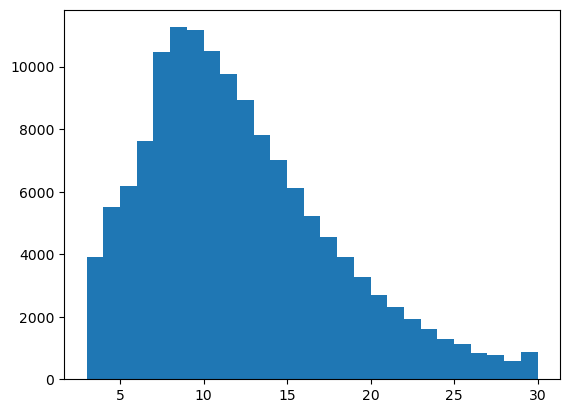

In [21]:
import matplotlib.pyplot as pl
plt.hist([len(x)-2 for x in original_data],27)

In [22]:
def get_lstm_model(max_sequence_length, vocab_size, embedding_dim):
    # Definizione degli input
    input_layer = Input(shape=(max_sequence_length,))

    # Embedding layer
    embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)

    # LSTM layer
    lstm_layer_1 = Bidirectional(LSTM(512, return_sequences=True))(embedding_layer)
    lstm_layer_2 = Bidirectional(LSTM(256, return_sequences=True))(lstm_layer_1)
    lstm_layer_3 = Bidirectional(LSTM(256, return_sequences=True))(lstm_layer_2)

    # Output layer
    output_layer = Dense(vocab_size, activation='softmax')(lstm_layer_3)

    # Definizione del modello
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compilazione del modello
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    # Stampa del summary del modello
    model.summary()

    return model


In [23]:
# Define hyperparameters
input_dim = 10001
output_dim = 32

vocab_size = 10000 #right

embedding_dim = 256

batch_size=64
epochs=15
max_sequence_length = max_sequence_len


In [24]:
from keras.callbacks import ModelCheckpoint
import os

# Definisci il percorso completo del file di salvataggio dei pesi
save_dir = '/Users/alessandrofolloni/Desktop/ProjectDL'
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, 'weights.h5')

# Crea il callback per il salvataggio dei pesi
checkpoint = ModelCheckpoint(weights_path, save_weights_only=True)

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 1, restore_best_weights = True)

In [26]:
# Creazione del modello
model = get_lstm_model(32,vocab_size,embedding_dim)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 256)           2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 32, 1024)         3149824   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32, 512)          2623488   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 512)          1574912   
 nal)                                                            
                                                             

In [27]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val),callbacks = [callback, checkpoint])

Epoch 1/15
1502/1502 [==============================] - 127s 76ms/step - loss: 2.3761 - accuracy: 0.6669 - val_loss: 2.1803 - val_accuracy: 0.6854
Epoch 2/15
1502/1502 [==============================] - 117s 78ms/step - loss: 2.0081 - accuracy: 0.6960 - val_loss: 1.8721 - val_accuracy: 0.7048
Epoch 3/15
1502/1502 [==============================] - 117s 78ms/step - loss: 1.7566 - accuracy: 0.7083 - val_loss: 1.6787 - val_accuracy: 0.7125
Epoch 4/15
1502/1502 [==============================] - 117s 78ms/step - loss: 1.5814 - accuracy: 0.7164 - val_loss: 1.5555 - val_accuracy: 0.7181
Epoch 5/15
1502/1502 [==============================] - 117s 78ms/step - loss: 1.4654 - accuracy: 0.7238 - val_loss: 1.4927 - val_accuracy: 0.7219
Epoch 6/15
1502/1502 [==============================] - 116s 77ms/step - loss: 1.3793 - accuracy: 0.7310 - val_loss: 1.4488 - val_accuracy: 0.7246
Epoch 7/15
1502/1502 [==============================] - 116s 78ms/step - loss: 1.3108 - accuracy: 0.7385 - val_loss: 1

In [28]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return (match.size/max(len(s),len(p)))

In [29]:
# Randomly select 3000 indices from x_test
num_samples = 3000
random_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)

# Get the corresponding input sequences
input_sequences = x_test[random_indices]

# Make predictions
predictions = model.predict(input_sequences)


94/94 [==============================] - 3s 15ms/step


In [30]:
total_score = 0.0

#this double loop is made beacause the model gives as output an array of dim (n_samples,32,10000)
#it's an array of n_samples_wanted=3000 sentences predicted where
#each sentence has 32 words and for each word there is an array of probabilities for each one of the vocab_size=10000 words

for i in range(3000):
  predicted_sentence = ""

  original_sentence_tokenized = y_test[random_indices[i]]
  original_sentence_tokenized = [original_sentence_tokenized]
  original_sentence = tokenizer.sequences_to_texts(original_sentence_tokenized)
  original_sentence = original_sentence[0].strip()

  for j in range(32):
    word_token = np.argmax(predictions[i][j])
    word = index_to_word.get(word_token, "<UNK>")
    predicted_sentence += word + " "
    
    
  original_sentence = original_sentence.replace("<start>", "").replace("<end>", "")
  predicted_sentence = predicted_sentence.replace("<start>", "").replace("<end>", "")
    
 
  
  single = score(original_sentence, predicted_sentence)
  total_score += single

total_score = total_score/3000

print("You got a average score of " + str(total_score))

You got a average score of 0.6427181574479134
